1. Importing and downloading library

In [18]:
! pip3 install praw
! pip3 install asyncpraw
import praw
import asyncpraw
from praw.models import MoreComments
import pandas as pd
import numpy as np
from textblob import TextBlob
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

2. Reddit authentication

In [19]:
# This connects to Reddit's API using my authentication credentials.

reddit = praw.Reddit(
    client_id='DYxnNTGyCtNtRUIHlDpGMA',
    client_secret='gUnRrYHBXvpMs06bJsBdoYkicK2isg',
    user_agent='NLP Project'
)

3. Subreddit Access

In [20]:
# Here I accessed the subreddit and print the basic information.
# You will see the title, number of comments and the karma score (popularity).

sub = reddit.subreddit('MusicRecommendations').top('all')

for sub in reddit.subreddit('MusicRecommendations').top('all'):
  print(sub.title, ',', sub.num_comments, ',', sub.score)

<ipython-input-20-c4c593b01663>:4: DeprecationWarning: Positional arguments for 'BaseListingMixin.top' will no longer be supported in PRAW 8.
Call this function with 'time_filter' as a keyword argument.
  sub = reddit.subreddit('MusicRecommendations').top('all')
<ipython-input-20-c4c593b01663>:6: DeprecationWarning: Positional arguments for 'BaseListingMixin.top' will no longer be supported in PRAW 8.
Call this function with 'time_filter' as a keyword argument.
  for sub in reddit.subreddit('MusicRecommendations').top('all'):
It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



My Dad died, looking for songs about saying Good-bye  , 4950 , 1031
Reccomend me the saddest, most depressing song you have  , 4980 , 840
What song do you believe is the “perfect” song (One choice only) , 4024 , 749
Songs that say ‘F*ck it all. Burn it down’ for when you’re just done , 2174 , 705
Songs for knowing you might die , 1064 , 641
Give me your favourite “f**k the system” songs , 2699 , 605
Quick, which song is stuck in your head right this very minute?? , 2529 , 594
Good songs which include a story as a part of the lyrics?  , 3656 , 590
Saddest Song? , 2455 , 586
Songs you hate so much that just the first note makes your brain gag , 5456 , 563
Give me a song that gave you Goosebumps the first time you heard it! , 2634 , 555
Songs you have actually shed a tear to? , 2142 , 552
Tell me a song that breaks your heart everytime you listen to it. , 2941 , 553
Recommend me your most saddest song of all time , 2925 , 529
Lyrically dense songs, please! , 3320 , 511
What songs are so h

4. Data Collection

In [21]:
# I set the maximum number of posts within the subreddit filtering to the top posts of this year.
def reddit_data(reddit, subreddit_name, limit=200, time_filter='year'):

# I create an empty list to store the data from the posts.
    posts_data=[]
    subreddit = reddit.subreddit(subreddit_name)
# This iterates through the top posts in the subreddit
    try:
        for post in subreddit.top(time_filter=time_filter, limit=limit):
            post.comments.replace_more(limit=0) # This removes the "load more comments, then creates a list"
            comments=[]
            for comment in post.comments.list():
                comments.append({
                    'body': comment.body, # Collects the comment text for each comment
                    'score': comment.score # Collects each comment's score
                })
            # for each post, it will store the title, score, number of comments and list of comments.
            posts_data.append({
                'title': post.title,
                'score': post.score,
                'num_comments': post.num_comments,
                'comments': comments
            })
        # This will print each success message with the number of posts collected aand errors during collection
        print(f"Successfully collected {len(posts_data)} posts")
    except Exception as e:
        print(f"Error collecting data: {e}")
    # Returns the collected data.
    return posts_data

5. Detecting the genre

In [22]:
# This defines the list of music genres within the comments to look for.
# This could be further expanded with other genres as well.
def music_genres(text):
    music_genres = ['rock', 'jazz', 'classical', 'hip hop', 'rap',
                    'indie', 'folk', 'house', 'r&b', 'blues',
                    'metal', 'punk', 'kpop', 'country', 'alternative',
                    'lofi', 'reggae', 'gospel', 'soul', 'afro']
    found_genres = [] # makes a list of genres found in the comments
    text_lower = text.lower()

    for genre in music_genres:
        if genre in text_lower:
            found_genres.append(genre)
    return found_genres # returns a list of the found genres from the comments

6. Cluster Analysis function

In [ ]:
# Takes the data (posts_data) and number of clusters to create
def analyze_clusters(posts_data, n_clusters=5):
    comments_text = [] # extract the comments and creats a list of comment texts
    for post in posts_data:
        for comment in post['comments']:
            comments_text.append(comment['body'])
    # Use term frequency vectorization and limits to 1000 features and removes english stop words.
    tfidf = TfidfVectorizer(
        max_features=1000,
        stop_words='english',
        ngram_range=(1, 2)
    )
    # Converts text into numerical features
    text_features = tfidf.fit_transform(comments_text)

    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(text_features.toarray())
    # applies K-means clustering and assigns each comment to one n_cluster
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(text_features.toarray())
    # creates a DataFrame that contains the original text, cluster and coordinates
    cluster_df = pd.DataFrame({
        'text': comments_text,
        'cluster': clusters,
        'x': reduced_features[:, 0],
        'y': reduced_features[:, 1]
    })
    # takes the cluster center vector, finds the terms with highest weight and stores them in a dictionary.
    feature_names = tfidf.get_feature_names_out()
    cluster_centers = kmeans.cluster_centers_
    terms_per_cluster = {}
    for i in range(n_clusters):
        center_vector = cluster_centers[i]
        top_indices = center_vector.argsort()[-10:][::-1]
        top_terms = [feature_names[idx] for idx in top_indices]
        terms_per_cluster[i] = top_terms

    return cluster_df, terms_per_cluster

7. Sentiment analysis function

In [ ]:
# here I use TextBlob to analyze the sentiment and returns a polarity score
def sentiment_analysis(text):
    return TextBlob(text).sentiment.polarity

8. Data Processing

In [ ]:
# Here is where the collected Reddit data is processed
posts_data = reddit_data(reddit, 'MusicRecommendations', limit=200, time_filter='year')
cluster_df, top_terms = analyze_clusters(posts_data, n_clusters=5)

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Successfully collected 200 posts


9. Visualization

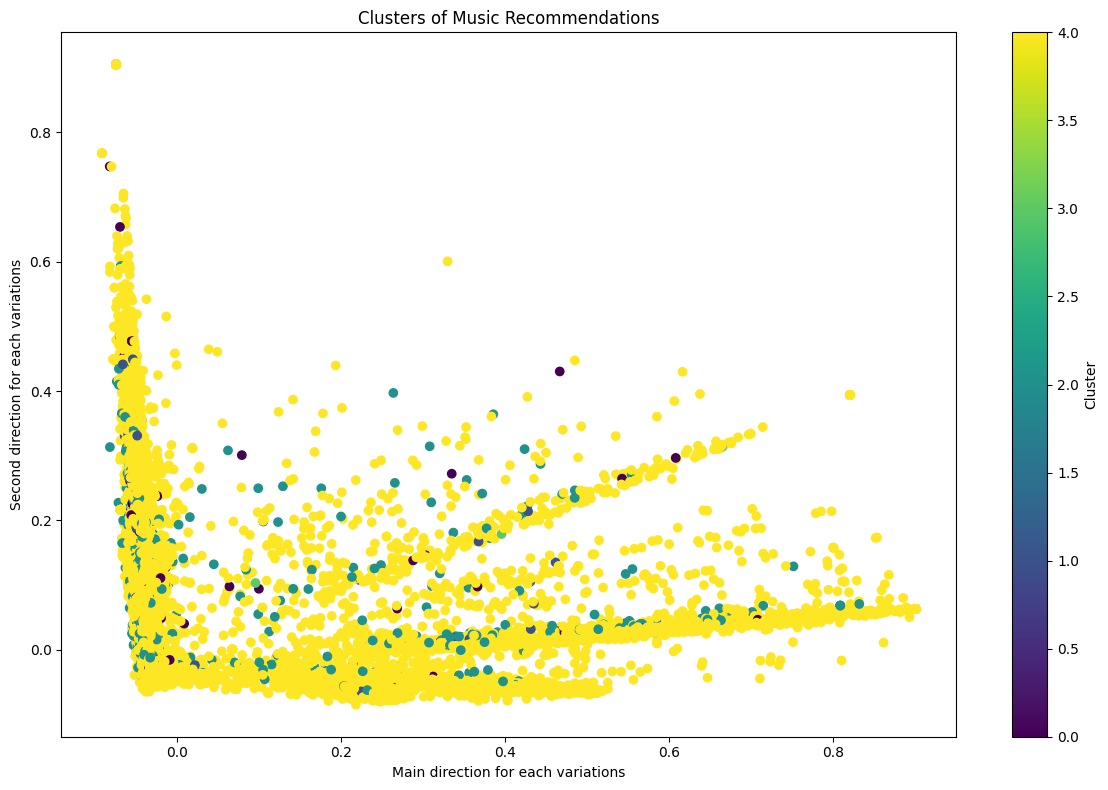

In [ ]:
# From the data collected, I created a scatter plot from the clusters.
plt.figure(figsize=(12, 8))
scatter = plt.scatter(cluster_df['x'], cluster_df['y'],
                     c=cluster_df['cluster'])
# Each color represents a different cluster of music recommendations
# Those witht he same color are grouped because the share similar characteristics
plt.title('Clusters of Music Recommendations')
plt.xlabel('Main direction for each variations')
plt.ylabel('Second direction for each variations')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

In [ ]:
all_genres =[]
all_sentiments =[]
total_comments = sum(len(post['comments']) for post in posts_data)
processed_comments = 0

print("Processing comments...")
# This loops through each post in posts_data in which it extracts the music genres from the comments.
for post in posts_data:
    for comment in post['comments']:
        try:
            genres = music_genres(comment['body'])
            sentiment = sentiment_analysis(comment['body'])
            all_genres.extend(genres) # The genres are then stored and is then added to all genres
            all_sentiments.append(sentiment)
            # Here it prints the progress for every 10 comments
            processed_comments += 1
            if processed_comments % 10 == 0:
                print(f"Processed {processed_comments}/{total_comments} comments")

        except Exception as e:
            print(f"Error processing comment: {e}")
            continue

Streaming output truncated to the last 5000 lines.
Processed 46060/96058 comments
Processed 46070/96058 comments
Processed 46080/96058 comments
Processed 46090/96058 comments
Processed 46100/96058 comments
Processed 46110/96058 comments
Processed 46120/96058 comments
Processed 46130/96058 comments
Processed 46140/96058 comments
Processed 46150/96058 comments
Processed 46160/96058 comments
Processed 46170/96058 comments
Processed 46180/96058 comments
Processed 46190/96058 comments
Processed 46200/96058 comments
Processed 46210/96058 comments
Processed 46220/96058 comments
Processed 46230/96058 comments
Processed 46240/96058 comments
Processed 46250/96058 comments
Processed 46260/96058 comments
Processed 46270/96058 comments
Processed 46280/96058 comments
Processed 46290/96058 comments
Processed 46300/96058 comments
Processed 46310/96058 comments
Processed 46320/96058 comments
Processed 46330/96058 comments
Processed 46340/96058 comments
Processed 46350/96058 comments
Processed 46360/960

In the MusicRecommendation subreddit, we see that Rock, Rap and metal are the most popular music genres to be recommended in the comments.

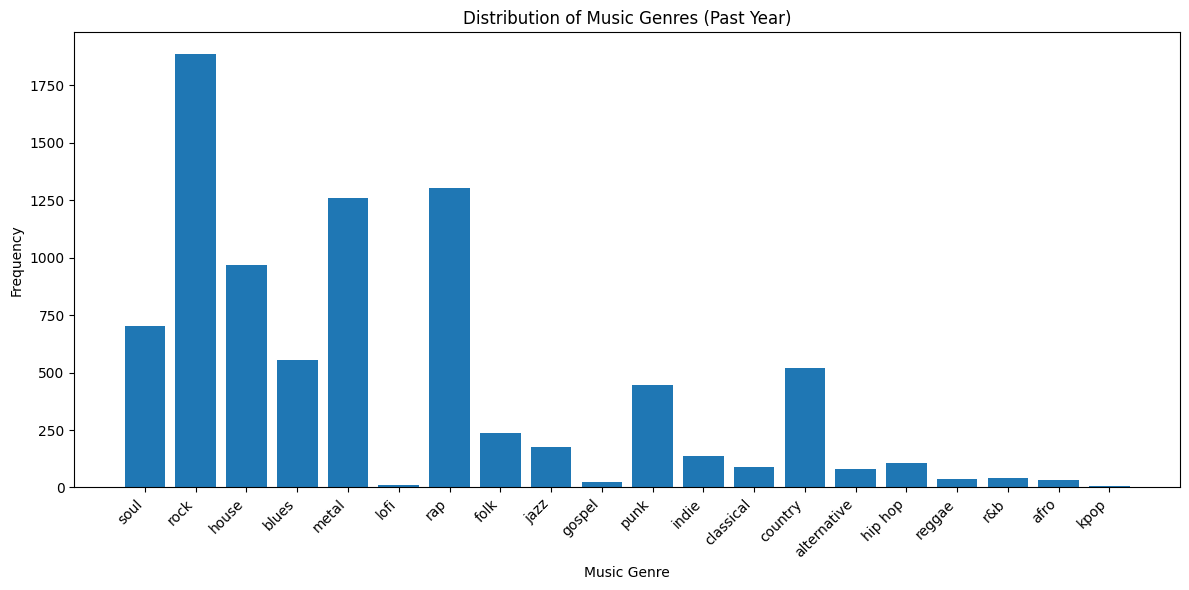

In [ ]:
#This subclass counts the frequency for each unique item
genre_count = Counter(all_genres)

plt.figure(figsize=(12, 6))
plt.bar(genre_count.keys(), genre_count.values())
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Music Genres (Past Year)')
plt.xlabel('Music Genre')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In the sentiment analysis, the comments within the subreddit are mostly neutral to positive.

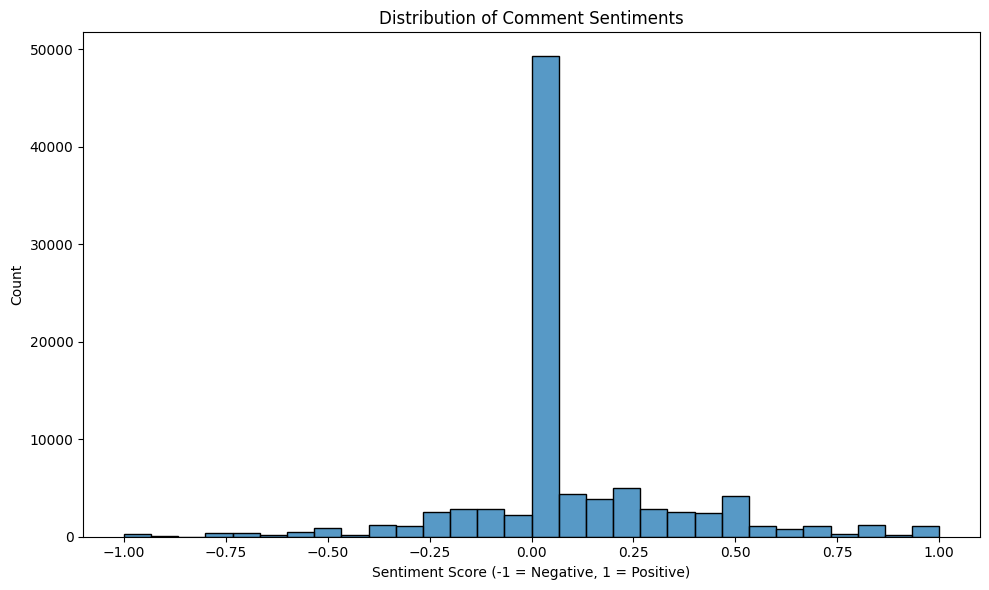

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(all_sentiments, bins=30)
plt.title('Distribution of Comment Sentiments')
plt.xlabel('Sentiment Score (-1 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()